# Training World Model to data encoded by VAE

In [1]:
import tensorflow as tf
%matplotlib notebook
%matplotlib inline
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import cv2
import datetime
import random
from tensorflow.keras.layers import Dense, LSTM, GRU, TimeDistributed, BatchNormalization, InputLayer

from IPython import display

from tqdm.notebook import tqdm, trange
import seaborn as sns
# sns.set()
tf.keras.backend.floatx()

latent_dim = 256
batch_size = 32
sequence_len = 32 * 4
image_shape = [128, 128, 3]

cvae_max_batch = 64

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

# Load CVAE  
Just to decode results of model for interpretation

In [3]:
from convolutional_vae_256 import CVAE
cvae = CVAE(latent_dim)
cvae.load_weights('models/cvae_wide_lat256_epoch620')

# Load encoded video

In [4]:
def batches_generator(batch_size, data_path):
    data = np.load(data_path).astype(np.float32)
    print('Dataset shape:', data.shape)
    assert sequence_len == data.shape[1]
    while True:
        for i in range(0, len(data), batch_size):
            yield data[i:i + batch_size]

train_gen = batches_generator(batch_size,
                              data_path='data_encoded/lat256_encoded_seqs3024.npy')

In [5]:
next(train_gen)[0].shape

Dataset shape: (3024, 128, 256)


(128, 256)

In [6]:
if False:
    %matplotlib notebook
    %matplotlib notebook

    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation

    def roll_demo():
        batch = next(train_gen)
        for entry in batch:
            for frame in entry:
                yield cvae.decode(frame[np.newaxis], apply_sigmoid=True)[0]

    demo_gen = roll_demo()
    im = plt.imshow(next(demo_gen))

    def update(frame):
        plt.title(frame)
        im.set_array(next(demo_gen))
        return [im]

    anim = FuncAnimation(plt.gcf(), update, frames=10000, interval=10, blit=True)

# MDN-RNN model

In [7]:
class MDN_RNN(tf.keras.Model):
    def __init__(self, n_mixtures, out_dims):
        super(MDN_RNN, self).__init__()
        
        self.n_mixtures = n_mixtures
        self.out_dims = out_dims

        self.rnn = tf.keras.Sequential(
            [
                InputLayer(input_shape=(None, latent_dim), dtype=tf.float32),
#                 Dense(64, activation='relu'),
#                 BatchNormalization(),
                GRU(512, return_sequences=True),
                BatchNormalization(),
#                 Dense(64, activation='relu'),
#                 BatchNormalization(),
                Dense(3 * n_mixtures * out_dims)
            ])
        
    def predict_distribution(self, x):
        ''' 
            x.shape = [batch_size, seq_length, latent_dim]
        '''
        x = self.rnn(x)
        
        mean, log_std, alpha = tf.split(x, 3, axis=2)
        mean = tf.reshape(mean, [-1, self.n_mixtures])
        log_std = tf.reshape(log_std, [-1, self.n_mixtures])
        alpha = tf.reshape(alpha, [-1, self.n_mixtures])
        alpha = tf.nn.softmax(alpha, axis=1)

        return mean, log_std, alpha
    
    def sample(self, x, temperature=1.0, verbose=False):
        # Predicting distribution
        mean, log_std, alpha = self.predict_distribution(x)
        std = tf.exp(log_std) * np.sqrt(temperature)
#         print(alpha)
#         alpha = alpha / temperature
#         alpha -= tf.reduce_max(alpha)
#         alpha = tf.nn.softmax(alpha, axis=-1)
#         print(alpha)
        
        seq_length = x.shape[1]
        
        # Picking component
        rnd = tf.random.uniform(shape=[x.shape[0] * self.out_dims * seq_length, 1], maxval=1)
        rnd = tf.repeat(rnd, self.n_mixtures, axis=-1)
        pdf = tf.cumsum(alpha, axis=-1)
        component_idx = np.argmax(pdf > rnd, axis=-1)
        
        # Gathering std and mean
        idx_flattened = tf.range(0, mean.shape[0]) * mean.shape[1] + component_idx
        component_std = tf.gather(tf.reshape(std, [-1]), idx_flattened)
        component_mean = tf.gather(tf.reshape(mean, [-1]), idx_flattened)

        # Sampling
        samples = tf.random.normal(shape=[x.shape[0] * self.out_dims * seq_length])
        samples = samples * component_std + component_mean
        samples = tf.reshape(samples, [-1, seq_length, self.out_dims])
        
        return samples
    
    def call(self, x):
        return self.sample(x)

# Training utils

In [8]:
def gaussian_pdf(x, mu, sigmasq):
    return (1 / tf.sqrt(2 * np.pi * sigmasq)) * tf.exp((-1 / (2 * sigmasq)) * (x - mu) ** 2)

def loss_fn(model, x, y_true):
    mean, log_std, alpha = model.predict_distribution(x)
    std = tf.exp(log_std) + 0.00001
    y_true = tf.reshape(y_true, [-1])

    prob_sum = 0
    for i in range(model.n_mixtures):
        prob = gaussian_pdf(y_true, mean[:, i], std[:, i])
        prob_sum += prob * alpha[:, i]

    log_prob_sum = tf.reduce_mean(-tf.math.log(prob_sum + 0.00001))
    return log_prob_sum

In [9]:
def train(model, train_gen, iterations, start_epoch=0):
#     @tf.function
    def gradient_step(model, x, y_true, optimizer):
        with tf.GradientTape() as tape:
            loss = loss_fn(model, x, y_true)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

#     @tf.function
    def fit(model, x, y, optimizer):
        loss = gradient_step(model, x, y, optimizer)
        return loss
    
    optimizer = tf.keras.optimizers.Adam(1e-3)
    t = trange(iterations)
    for i in t:
        batch = next(train_gen)
        x, y = batch[:, :-1], batch[:, 1:]
        loss = fit(model, x, y, optimizer)
        
        tf.summary.scalar('loss', data=loss.numpy(), step=start_epoch + i)
        t.set_description('%.2f' % loss.numpy())

# Train

In [10]:
n_mixtures = 6
model = MDN_RNN(n_mixtures=n_mixtures, out_dims=latent_dim)

In [11]:
# Tensorboard logging
model_name = f'mdnrnn-lat{latent_dim}-mix{n_mixtures}-gru'
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_' + model_name
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

In [ ]:
train(model, train_gen, 10000, start_epoch=0)

In [13]:
model_name = f'./models/mdn-rnn_lat{latent_dim}'
print('Saved as ', model_name)
model.save_weights(model_name)

Saved as  ./models/mdn-rnn_lat256


In [14]:
# model_name = f'./models/mdn-rnn_lat{latent_dim}'
# print('Loaded', model_name)
# model.load_weights(model_name)

# Validation

<IPython.core.display.Javascript object>


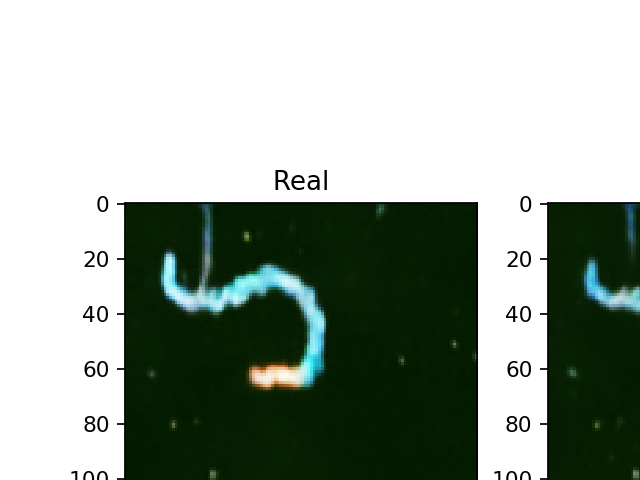

In [30]:
def generate_demo_sequences():
    demo_real = []
    demo_generated = []

    for i in trange(20):
        seq_len = 32# * 4
        sequence_real = next(train_gen)[0][:seq_len]
        demo_real += [frame for frame in sequence_real]
        sequence = sequence_real[np.newaxis, 0]
        for i in range(seq_len):
            latent = model.sample(np.expand_dims(sequence, axis=0), temperature=1)[0, -1].numpy().reshape([-1, latent_dim])
            sequence = np.concatenate([sequence, latent])
            demo_generated.append(latent[0])
    return np.array(demo_real), np.array(demo_generated)

real, generated = generate_demo_sequences()


%matplotlib notebook
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def get_frame(sequence, i):
    return cvae.decode(sequence[i % len(sequence), np.newaxis], apply_sigmoid=True)[0]

plt.subplot(1, 2, 1)
plt.title('Real')
im1 = plt.imshow(get_frame(real, 0))
plt.subplot(1, 2, 2)
plt.title('Generated')
im2 = plt.imshow(get_frame(generated, 0))

def update(frame):
    im1.set_array(get_frame(real, frame))
    im2.set_array(get_frame(generated, frame))
    return [im]

anim = FuncAnimation(plt.gcf(), update, frames=len(generated), interval=100, blit=True)

In [31]:
display.HTML(anim.to_html5_video())

In [ ]:
film = np.array([get_frame(i).numpy() for i in trange(300)])
film = np.clip(film * 255, 0, 255)
# film = np.rollaxis(film, 3, 1)  

In [ ]:
from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(list(film), fps=20).resize(2.4)
clip.write_gif('mdn-rnn.gif')

In [ ]:
from IPython.display import Image
Image(filename="mdn-rnn.gif")